# Time Series Analysis with ARIMA
ARIMA (AutoRegressive Integrated Moving Average) is a popular and widely used statistical method for analyzing and forecasting time series data. It is a class of models that encompasses a combination of autoregressive (AR), differencing (I), and moving average (MA) components.<br><br>

- AutoRegressive (AR): This component models the relationship between an observation and a number of lagged observations (i.e., past values in the time series).
- Integrated (I): This component represents the differencing of raw observations in order to make the time series stationary (i.e., removing trends and seasonality).
- Moving Average (MA): This component models the relationship between an observation and a residual error from a moving average model applied to lagged observations.<br><br>

ARIMA models are suitable for time series data that exhibit temporal dependencies, such as trends, seasonality, and autocorrelation. They are widely used in various fields, including economics, finance, and environmental science, for tasks such as forecasting future values, analyzing historical patterns, and identifying underlying patterns in the data.

## Libraries

In [26]:
import warnings
warnings.filterwarnings('ignore', category=Warning)
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize']=(20.0, 10.0)
plt.rcParams.update({'font.size':12})
plt.style.use('ggplot')

## Data Exploration
### Load Data

In [27]:
data = pd.read_csv('international-airline-passengers.csv',
                   engine='python',
                   skipfooter=3)

# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index(['Month'], inplace=True)

### Ploting raw data

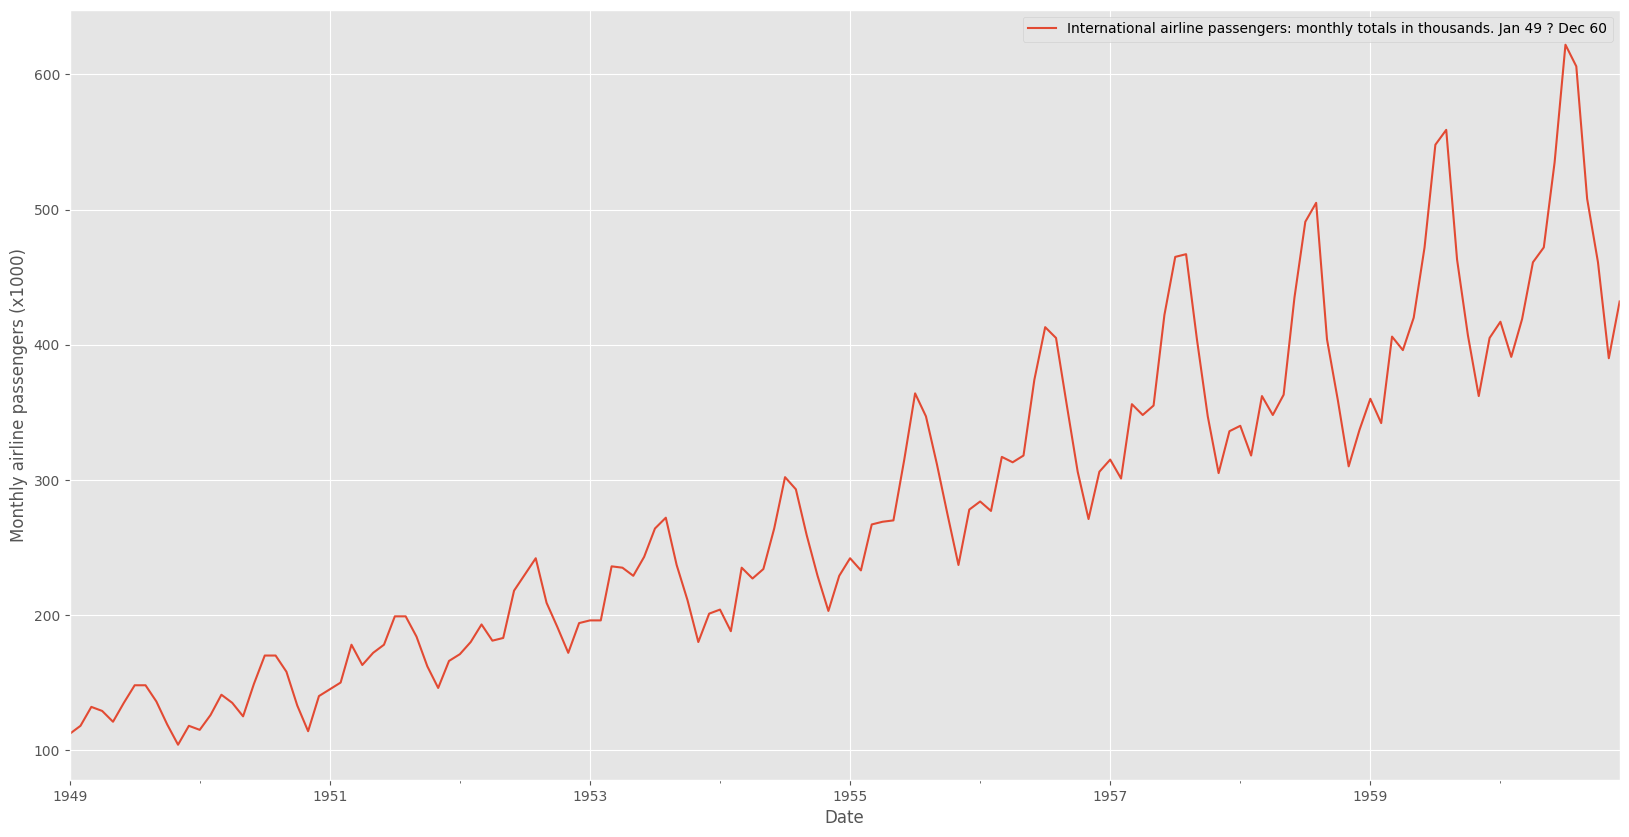

In [28]:
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

Two obvious patterns appear in the data, an overall increase in the number of passengers over time, and 12 months seasonality with peaks corresponding toi the northern emisphere summer period.

## Concepts Overview
### ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q):<br><br>

- p is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- d is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- q is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.<br><br>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series.

### ARIMA variables
Define the d and q parameters to take any value between 0 and 1

In [29]:
q = d = range(0, 2)

Define the p parameters to take any value between 0 and 3

In [30]:
p = range(0, 4)

Generate all different combinations of p, q and q triplets

In [31]:
pdq = list(itertools.product(p, d, q))

Generate all different combinations of seasonal p, q, and q triplets

In [32]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("Examples of parameter combinations for Seasonal ARIMA...")
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We select a subset of teh data series as training data, say the first 11 years. Our goal is to predict the last year of the series based on this input.

In [33]:
train_data = data['1949-01':'1959-12']
test_data = data['1960-01':'1960-12']

In [34]:
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data, order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False, enforce_invertibility=False)
            results=mod.fit()
            print('SARIMAX{}x{} - AIC: {}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [35]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 618.2055119838061 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [36]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data, 
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1], 
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results=mod.fit()

Once the model has been fitted, we can check if does what we expect and if the assumptions we made are ciolated to do this, we can use the plot_diagnostics method.

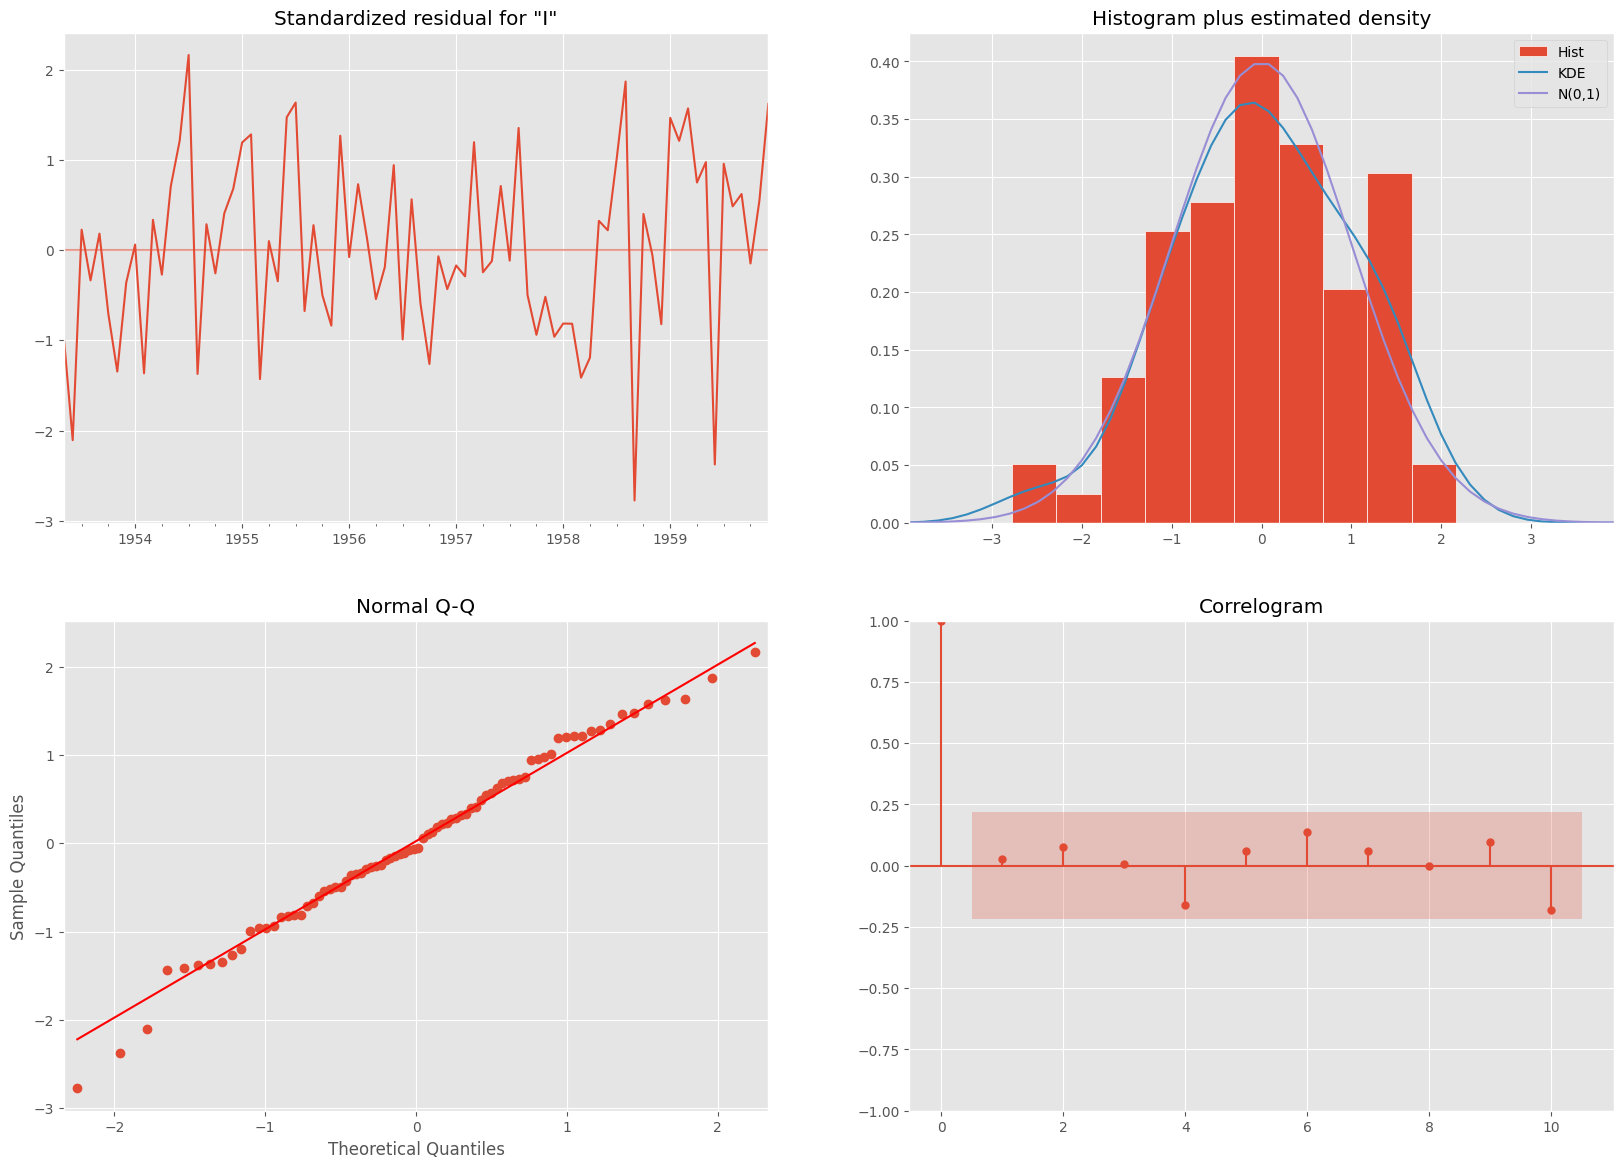

In [37]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distributio of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a stron indication that the residuals are normally distributed.

## Results
Now let's create some predictions. We will use three methods:<br><br>
1. In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies tha teach forecasted point is used to predict the following one.

In [38]:
pred0=results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci=pred0.conf_int()

2. In sample prediction with dynamic forecasting of the last year (1959). Again, the model is used to predict data that the model was built on.

In [39]:
pred1=results.get_prediction(start='1958-01-01', dynamic=False)
pred1_ci=pred1.conf_int()

3. "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [40]:
pred2=results.get_forecast('1962-12-01')
pred2_ci=pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.493347
1960-02-01    397.831523
1960-03-01    460.857119
1960-04-01    449.449233
1960-05-01    474.553468
1960-06-01    537.847918
1960-07-01    614.884090
1960-08-01    628.208835
1960-09-01    519.334442
1960-10-01    462.252514
1960-11-01    412.161444
1960-12-01    452.661753
Freq: MS, Name: predicted_mean, dtype: float64


Let's plot all this

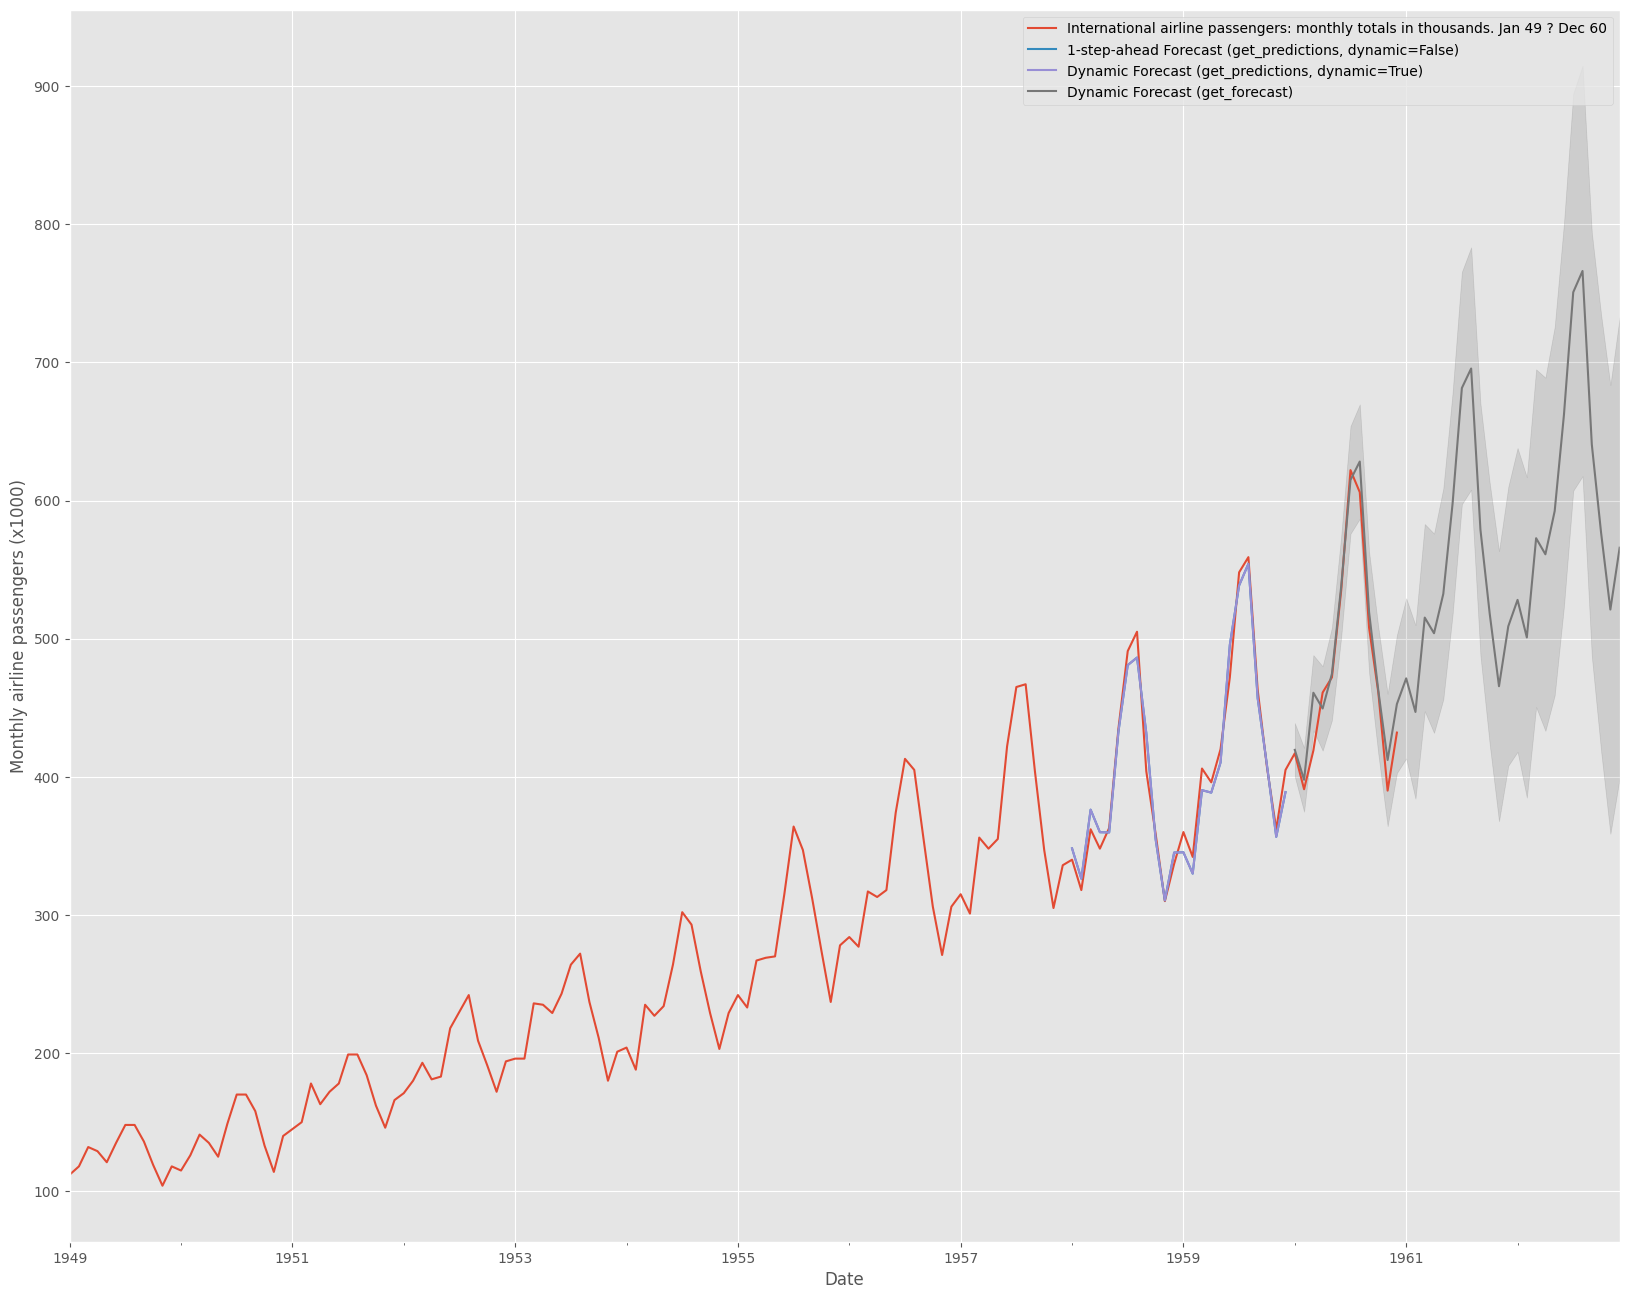

In [41]:
ax=data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label="1-step-ahead Forecast (get_predictions, dynamic=False)")
pred1.predicted_mean.plot(ax=ax, label="Dynamic Forecast (get_predictions, dynamic=True)")
pred2.predicted_mean.plot(ax=ax, label="Dynamic Forecast (get_forecast)")
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:,0], pred2_ci.iloc[:,1], color='k', alpha=.1)
plt.ylabel("Monthly airline passengers (x1000)")
plt.xlabel("Date")
plt.legend()
plt.show()



Upon observing the graph, it appears that the model effectively captures the behavior of the time series. The blue and purple lines closely align with the red ground truth, as anticipated. Of particular interest is the gray line, representing the out-of-sample prediction. Despite the simplicity of the time series, the ARIMA model accurately forecasts the values for 1960.

To assess the accuracy of the 1960 prediction quantitatively, we can utilize metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE). However, these metrics are absolute and thus dependent on the scale of the data. While they are commonly used for comparing different methods on the same dataset, it would be more informative in this context to evaluate the error relative to the magnitude of the time series being predicted.

One frequently employed measure for percentage error is the Mean Absolute Percentage Error (MAPE). It is important to note that MAPE has certain limitations in specific scenarios, such as the potential for division by zero. Enhanced measures have been proposed to address these issues. For this example, we will utilize MAPE as our error measure. For more comprehensive information on alternative measures, please refer to the following resource: [otexts](https://www.otexts.org/fpp/2/5.)


In [42]:
prediction=pred2.predicted_mean['1960-01-01':'1960-12-01'].values

# Flatten nested list
truth=list(itertools.chain.from_iterable(test_data.values))

# Mean Absolute Percentage Error
MAPE=np.mean(np.abs((truth-prediction)/truth))*100
print(f"The Mean Absolute Percentage Error for the forecast of year 1960 is: {np.round(MAPE, 2)}%")

The Mean Absolute Percentage Error for the forecast of year 1960 is: 2.81%
